In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_stata("stanford data set/HCMST 2017 fresh sample for public sharing draft v1.1.dta")

In [4]:
df = df.replace({'Yes': 1, 'No': 0})

In [5]:
df.head()

,CaseID,CASEID_NEW,qflag,weight1,weight1_freqwt,weight2,weight1a,weight1a_freqwt,weight_combo,weight_combo_freqwt,...,hcm2017q24_met_through_family,hcm2017q24_met_through_friend,hcm2017q24_met_through_as_nghbrs,hcm2017q24_met_as_through_cowork,w6_subject_race,interracial_5cat,partner_mother_yrsed,subject_mother_yrsed,partner_yrsed,subject_yrsed
0,2,2014039,Qualified,NaN,NaN,0.8945,NaN,NaN,0.277188,19240.0,...,no,no,no,no,White,no,12.0,14.0,12.0,14.0
1,3,2019003,Qualified,0.9078,71115.0,NaN,0.9026,70707.0,1.020621,70841.0,...,no,no,no,yes,White,no,12.0,16.0,17.0,17.0
2,5,2145527,Qualified,0.7205,56442.0,NaN,0.7164,56121.0,0.810074,56227.0,...,no,no,no,no,White,no,9.0,7.5,14.0,17.0
3,6,2648857,Qualified,1.2597,98682.0,1.3507,1.2524,98110.0,0.418556,29052.0,...,no,no,no,no,White,no,16.0,12.0,12.0,12.0
4,7,2623465,Qualified,0.8686,68044.0,NaN,0.8636,67652.0,0.976522,67781.0,...,no,no,yes,no,White,no,14.0,17.0,16.0,16.0


# Data Cleaning

In [126]:
columns = ['w6_q21a_year', 'w6_q21a_month', 'w6_q21b_year', 'w6_q21b_month', 'w6_q21c_year', 'w6_q21c_month', 'w6_q21d_year', 'w6_q21d_month', 'w6_q19', 'ppage', 'w6_q9']

In [127]:
for column in columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

In [152]:
df.isna().sum()

CaseID                              0
CASEID_NEW                          0
qflag                               0
weight1                           516
weight1_freqwt                    516
                                 ... 
relationship_satisfaction_num     654
relationship_satisfaction_norm    663
relationship_duration             247
relationship_duration_norm        247
compatibility_score               763
Length: 290, dtype: int64

In [52]:
# Mapping of categories to numerical values
category_mapping = {
    'Refused': np.nan,
    'Excellent': 5,
    'Good': 4,
    'Fair': 3,
    'Poor': 2,
    'Very Poor': 1
}

# Replace the values in the Q34 column using the mapping
df['satisfaction_score'] = df['Q34'].map(category_mapping)

In [53]:
df['satisfaction_score'].value_counts()

5.0    1706
4.0     884
3.0     202
2.0      32
1.0      23
Name: satisfaction_score, dtype: int64

In [16]:
df['relationship_duration'] = (df['w6_q21b_year'] - df['w6_q21a_year']) * 12 + (df['w6_q21b_month'] - df['w6_q21a_month'])

TypeError: unsupported operand type(s) for -: 'Categorical' and 'Categorical'

In [54]:
currentYear = 2017
df["RelationshipDuration"] = currentYear - df["w6_q21b_year"]
df["RelationshipDuration"].unique()

array([ 0., 22., 11.,  4., 34., 35., 50., nan,  9.,  3.,  8.,  6., 13.,
       10., 15., 43., 12., 17., 27., 25.,  2.,  7., 31., 40., 18., 29.,
        1., 46., 20., 41., 49., 45., 62., 57., 28., 60.,  5., 30., 32.,
       56., 36., 52., 48., 23., 44., 47., 53., 24., 14., 42., 54., 26.,
       16., 59., 21., 38., 39., 33., 37., 65., 55., 75., 19., 64., 63.,
       51., 58., 61., 67., 69., 66., 68., 70.])

In [242]:
satisfaction_mapping = {
    'Refused': -1,
    'Excellent': 5,
    'Good': 4,
    'Fair': 3,
    'Poor': 2,
    'Very Poor': 1
}

# Replace satisfaction categories with numerical values
df['relationship_satisfaction_num'] = df['Q34'].map(satisfaction_mapping)

# Normalize relationship satisfaction (excluding 'Refused' responses)
df['relationship_satisfaction_norm'] = df[df['relationship_satisfaction_num'] != -1].apply(
    lambda row: (row['relationship_satisfaction_num'] - 1) / 4, axis=1
)

# Calculate relationship duration in months
df['relationship_duration'] = (df['w6_q21b_year'] - df['w6_q21a_year'])

# Normalize relationship duration
duration_min = df['relationship_duration'].min()
duration_max = df['relationship_duration'].max()
df['relationship_duration_norm'] = (df['relationship_duration'] - duration_min) / (duration_max - duration_min)

# Calculate compatibility score
df['compatibility_score'] = 0.6 * df['relationship_satisfaction_norm'] + 0.3 * df['relationship_duration_norm'] + 0.1 * df['w6_q19']

In [247]:
(df['compatibility_score'] < 0.8).value_counts()

True     2716
False     794
Name: compatibility_score, dtype: int64

In [244]:
df['compatibility_score']

0            NaN
1       0.765455
2       0.550000
3            NaN
4       0.700000
          ...   
3505    0.700000
3506    0.455455
3507    0.550000
3508    0.555455
3509    0.400000
Name: compatibility_score, Length: 3510, dtype: float64

In [248]:
features = ['ppgender', 'ppethm', 'ppage', 'ppeduc', 'w6_q4', 'w6_q6b', 'w6_q9', 'w6_q10', 'w6_q6a']
target = 'compatibility_score'

In [249]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [250]:
dfClean = df[features + [target]].dropna()

In [251]:
cat_features = ['ppgender', 'ppethm', 'ppeduc', 'w6_q4', 'w6_q6b', 'w6_q10', 'w6_q6a']

In [252]:
def encode_categorical_features(data, features):
    """Encode categorical features using one-hot encoding."""
    enc = OneHotEncoder(handle_unknown='ignore')
    encoded_features = enc.fit_transform(data[features]).toarray()
    encoded_feature_names = enc.get_feature_names_out(features)

    df_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=data.index)
    data = pd.concat([data.drop(features, axis=1), df_encoded], axis=1)

    return data

# Linear Regression

In [253]:
dfClean = encode_categorical_features(dfClean, cat_features)
X = dfClean.drop(target, axis=1)
y = dfClean[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [254]:

# Entraînement du modèle de régression linéaire
reg = LinearRegression()
reg.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = reg.predict(X_test)

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

RMSE: 0.12588157155414
MSE: 0.01584617005694007


In [255]:
y_test

3428    0.005455
3468    0.705455
2905    0.705455
3226    0.700000
2052    0.550000
          ...   
2795    0.705455
176     0.700000
445     0.600000
2634    0.550000
1974    0.605455
Name: compatibility_score, Length: 825, dtype: float64

In [256]:
df['ppage'].value_counts()

27    97
28    92
58    89
55    85
57    83
      ..
93     2
89     2
91     2
92     1
88     1
Name: ppage, Length: 76, dtype: int64

In [257]:
df['w6_q6a'].unique()

['No (Not Latino or Hispanic)', NaN, 'Yes, Mexican, Mexican American, Chicano', 'Yes, Other Latino/Hispanic', 'Yes, Puerto Rican', 'Yes, Cuban', 'Refused']
Categories (6, object): ['Refused' < 'No (Not Latino or Hispanic)' < 'Yes, Mexican, Mexican American, Chicano' < 'Yes, Puerto Rican' < 'Yes, Cuban' < 'Yes, Other Latino/Hispanic']

In [268]:
# Create custom datapoint
custom_datapoint = {
    'ppgender': 'Male',
    'ppethm': 'White, Non-Hispanic',
    'ppage': 22,
    'ppeduc': 'Master\'s degree',
    'w6_q4': '[Partner Name] is Female',
    'w6_q6b': 'Black, Non-Hispanic',
    'w6_q6a': 'No (Not Latino or Hispanic)',
    'w6_q9': 20,
    'w6_q10': 'Bachelor\'s degree'
}

# Convert to dataframe
custom_datapoint = pd.DataFrame(custom_datapoint, index=[0])
custom_datapoint = encode_categorical_features(custom_datapoint, cat_features)

In [280]:
dfClean.shape[1]

54

In [269]:
# Compare cols to X_train and fill missing cols with 0

In [270]:
for col in X_train.columns:
    if col not in custom_datapoint.columns:
        custom_datapoint[col] = 0

In [271]:
# Order cols to match X_train
custom_datapoint = custom_datapoint[X_train.columns]

In [272]:
reg.predict(custom_datapoint)

array([0.57082051])

In [288]:
from tensorflow import keras

# Define the model architecture
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(53,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

# Print the shape of the training data
print("Shape of X_train:", X_train.shape) # This should be (number_of_rows, 53)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

Shape of X_train: (1922, 53)


In [282]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
61/61 [==============================] - 0s 2ms/step - loss: 1.5098 - mae: 0.8063 - val_loss: 0.1168 - val_mae: 0.2733
Epoch 2/100
61/61 [==============================] - 0s 843us/step - loss: 0.1010 - mae: 0.2550 - val_loss: 0.0680 - val_mae: 0.2080
Epoch 3/100
61/61 [==============================] - 0s 792us/step - loss: 0.0524 - mae: 0.1825 - val_loss: 0.0405 - val_mae: 0.1662
Epoch 4/100
61/61 [==============================] - 0s 808us/step - loss: 0.0287 - mae: 0.1327 - val_loss: 0.0217 - val_mae: 0.1141
Epoch 5/100
61/61 [==============================] - 0s 781us/step - loss: 0.0230 - mae: 0.1183 - val_loss: 0.0182 - val_mae: 0.1011
Epoch 6/100
61/61 [==============================] - 0s 826us/step - loss: 0.0245 - mae: 0.1228 - val_loss: 0.0181 - val_mae: 0.1003
Epoch 7/100
61/61 [==============================] - 0s 778us/step - loss: 0.0188 - mae: 0.1071 - val_loss: 0.0181 - val_mae: 0.1056
Epoch 8/100
61/61 [==============================] - 0s 778us/step - lo

In [284]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print("Mean Absolute Error:", mae)

26/26 [==============================] - 0s 395us/step - loss: 0.0214 - mae: 0.1185
Mean Absolute Error: 0.11853589862585068


In [285]:
model.predict(custom_datapoint)

1/1 [==============================] - 0s 33ms/step


array([[0.45309287]], dtype=float32)

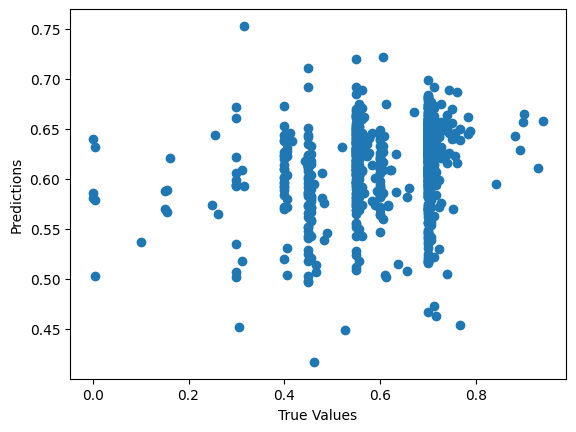

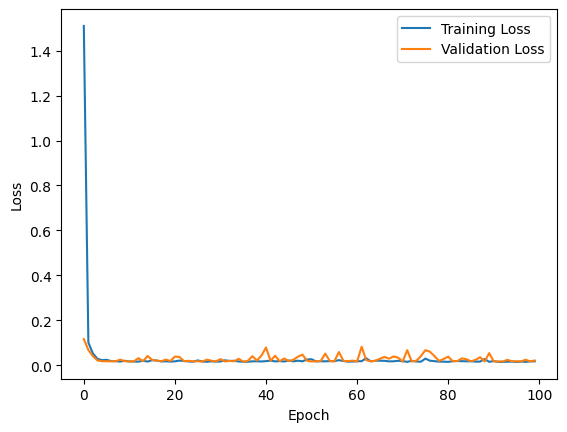

In [287]:
# Plot y pref vs y test and draw a line of best fit
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()